In [16]:
%env ISTIO_HOME=/home/clive/work/istio/istio-0.8.0

env: ISTIO_HOME=/home/clive/work/istio/istio-0.8.0


In [20]:
!kubectl create -f ${ISTIO_HOME}/install/kubernetes/helm/helm-service-account.yaml

serviceaccount "tiller" created
clusterrolebinding "tiller" created


In [21]:
!helm init --service-account tiller

$HELM_HOME has been configured at /home/clive/.helm.

Tiller (the Helm server-side component) has been installed into your Kubernetes Cluster.
Happy Helming!


In [23]:
!helm install ${ISTIO_HOME}/install/kubernetes/helm/istio --name istio --namespace istio-system \
    --set global.proxy.includeIPRanges="10.0.0.1/8"

NAME:   istio
LAST DEPLOYED: Tue Jun 19 18:45:17 2018
NAMESPACE: istio-system
STATUS: DEPLOYED

RESOURCES:
==> v1beta1/CustomResourceDefinition
NAME                                   AGE
deniers.config.istio.io                45s
rbacs.config.istio.io                  45s
prometheuses.config.istio.io           45s
servicecontrolreports.config.istio.io  45s
logentries.config.istio.io             45s
listentries.config.istio.io            45s
kuberneteses.config.istio.io           45s
fluentds.config.istio.io               45s
kubernetesenvs.config.istio.io         45s
stdios.config.istio.io                 45s
circonuses.config.istio.io             45s
listcheckers.config.istio.io           45s
solarwindses.config.istio.io           45s
apikeys.config.istio.io                45s
rules.config.istio.io                  45s
quotas.config.istio.io                 45s
reportnothings.config.istio.io         45s
tracespans.config.istio.io             45s
serviceroles.config.istio.io           

In [24]:
!kubectl apply -f ${ISTIO_HOME}/install/kubernetes/addons/grafana.yaml

service "grafana" created
deployment "grafana" created
serviceaccount "grafana" created


```
kubectl -n istio-system port-forward $(kubectl -n istio-system get pod -l app=grafana -o jsonpath='{.items[0].metadata.name}') 3000:3000
```
http://localhost:3000/dashboard/db/istio-dashboard

In [ ]:
!kubectl create namespace seldon

In [ ]:
!kubectl label namespace seldon istio-injection=enabled

In [25]:
!kubectl apply -f ../../../notebooks/resources/ambassador-rbac.yaml -n seldon

clusterrole "ambassador" created
serviceaccount "ambassador" created
clusterrolebinding "ambassador" created
service "ambassador" created
service "ambassador-admin" created
deployment "ambassador" created


In [26]:
!helm install ../../../helm-charts/seldon-core-analytics --name seldon-core-analytics \
    --set grafana_prom_admin_password=password \
    --set persistence.enabled=false \
    --namespace seldon

NAME:   seldon-core-analytics
LAST DEPLOYED: Tue Jun 19 18:49:33 2018
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/Service
NAME                      TYPE       CLUSTER-IP      EXTERNAL-IP  PORT(S)       AGE
alertmanager              ClusterIP  10.97.10.96     <none>       80/TCP        1s
grafana-prom              NodePort   10.101.14.81    <none>       80:31040/TCP  1s
prometheus-node-exporter  ClusterIP  None            <none>       9100/TCP      1s
prometheus-seldon         ClusterIP  10.103.146.190  <none>       80/TCP        1s

==> v1/Pod(related)
NAME                                      READY  STATUS    RESTARTS  AGE
grafana-prom-import-dashboards-mp82k      0/2    Init:0/1  0         1s
alertmanager-deployment-7fbfdfdfb6-tr8fj  0/2    Init:0/1  0         1s
grafana-prom-deployment-7b45fb85d4-htvvh  0/2    Init:0/1  0         1s
prometheus-node-exporter-wt5hk            0/1    Pending   0         1s
prometheus-deployment-cbfd78cc7-qwxx9     0/2    Pending   0         1

```
kubectl port-forward $(kubectl get pods -n seldon -l app=grafana-prom-server -o jsonpath='{.items[0].metadata.name}') -n seldon 3001:3000
```

http://localhost:3001/dashboard/db/prediction-analytics?refresh=5s&orgId=1

In [27]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Context "minikube" modified.


In [28]:
!mkdir -p proto
!cp ../../../proto/prediction.proto ./proto
!python -m grpc.tools.protoc -I. --python_out=. --grpc_python_out=. ./proto/prediction.proto

In [35]:
%matplotlib inline
import utils
mnist = utils.download_mnist()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [ ]:
!kubectl create -f mnist_v1.json

In [ ]:
!kubectl get pods

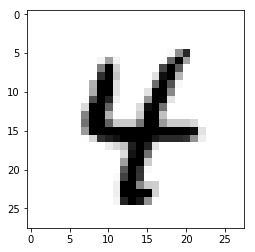

Route:{}
{
  "0": "0.08",
  "1": "0.10",
  "2": "0.09",
  "3": "0.09",
  "4": "0.12",
  "5": "0.09",
  "6": "0.10",
  "7": "0.11",
  "8": "0.09",
  "9": "0.12"
}


In [30]:
utils.predict_rest_mnist(mnist,"mnist-classifier")

In [31]:
!kubectl label nodes $(kubectl get nodes -o jsonpath='{.items[0].metadata.name}') role=locust

node "minikube" labeled


In [32]:
!helm install seldon-core-loadtesting --name loadtest  \
    --namespace seldon \
    --repo https://storage.googleapis.com/seldon-charts \
    --set locust.script=mnist_rest_locust.py \
    --set locust.host=http://mnist-deployment:8000 \
    --set oauth.enabled=false \
    --set oauth.key=oauth-key \
    --set oauth.secret=oauth-secret \
    --set locust.hatchRate=1 \
    --set locust.clients=1 \
    --set loadtest.sendFeedback=1 \
    --set locust.minWait=0 \
    --set locust.maxWait=0 \
    --set replicaCount=1 \
    --set data.size=784


NAME:   loadtest
LAST DEPLOYED: Tue Jun 19 18:53:23 2018
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/Pod(related)
NAME                   READY  STATUS    RESTARTS  AGE
locust-slave-1-jmjbs   0/2    Init:0/1  0         0s
locust-master-1-6xhvd  0/2    Init:0/1  0         0s

==> v1/ReplicationController
NAME             DESIRED  CURRENT  READY  AGE
locust-slave-1   1        1        0      0s
locust-master-1  1        1        0      0s

==> v1/Service
NAME             TYPE      CLUSTER-IP     EXTERNAL-IP  PORT(S)                                       AGE
locust-master-1  NodePort  10.102.138.69  <none>       5557:31388/TCP,5558:32352/TCP,8089:30904/TCP  0s




In [ ]:
!pygmentize istio_canary_v1.yaml

In [ ]:
!istioctl create -f istio_canary_v1.yaml

In [ ]:
!kubectl apply -f mnist_v2.json

In [ ]:
for i in range (100):
    utils.predict_rest_mnist(mnist,"mnist-classifier")

In [34]:
!istioctl replace -f istio_canary_v2.yaml

Updated config virtual-service/seldon/mnist-deployment to revision 3005
Updated config destination-rule/seldon/mnist-deployment to revision 3006


# Tear Down

In [15]:
!helm delete loadtest --purge

release "loadtest" deleted
